## Projet 6 : Classifier automatiquement des bien de consommation
## <a name="C4"> Partie 1 : étude de faisabilité des features texte</a>

Dans le cadre de notre mission en tant que Data Scientist chez "Place de marché", nous avons pour objectif d'automatiser l'attribution des catégories pour les articles proposés sur notre plateforme e-commerce. Actuellement, cette tâche est réalisée manuellement par les vendeurs, ce qui peut engendrer des erreurs et des incohérences. Avec la croissance prévue du volume d'articles, il devient crucial de développer un moteur de classification automatique des articles basé sur leur description textuelle et leur image. Linda, notre Lead Data Scientist, nous a confié la réalisation d'une étude de faisabilité pour ce projet. Cette étude comprendra l'analyse des données textuelles et visuelles, l'extraction de features, et l'évaluation de la possibilité de regrouper les articles par catégorie de manière automatique.

Sommaire :  
   
- Préparation des données
- Segmentation des produits via leur description  
  
Numérisation du texte : approches fréquentistes  
- CountVectorizer
- TF-IDF  
  
Numérisation du texte : approche embedding  
- Word2Vec
- BERT
- USE
  
Conclusion

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy
from numpy import triu
import plotly.express as px
import os
import os,shutil
import pandas as pd
import numpy as np
import datetime as dt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import manifold, decomposition
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import nltk
import gensim
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords 
from nltk import word_tokenize
from collections import defaultdict
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import FrenchStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer
from transformers import TFBertModel
import time
import warnings
warnings.filterwarnings("ignore")

print("Librairies importées avec succès !")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lokma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lokma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lokma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lokma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Librairies importées avec succès !


In [5]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.2.2
NumPy: 1.26.4
Matplotlib: 3.8.4
Seaborn: 0.13.2


- Création des fonctions utiles

In [6]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


In [7]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(25, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


- Lecture des fichiers CSV

In [8]:
raw_data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv', sep = ",")


- Répertoire des images

In [9]:
img_path = r'Images/'

## <a name="C4"> Préparation des données</a>

- Informations générales

In [10]:
print(raw_data.shape)
raw_data.head()

(1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [11]:
data_info(raw_data)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
uniq_id,1050,1050,object,0,0.00
crawl_timestamp,1050,149,object,0,0.00
product_url,1050,1050,object,0,0.00
product_name,1050,1050,object,0,0.00
product_category_tree,1050,642,object,0,0.00
pid,1050,1050,object,0,0.00
retail_price,1049,354,float64,1,0.10
discounted_price,1049,424,float64,1,0.10
image,1050,1050,object,0,0.00


- Valeurs manquantes

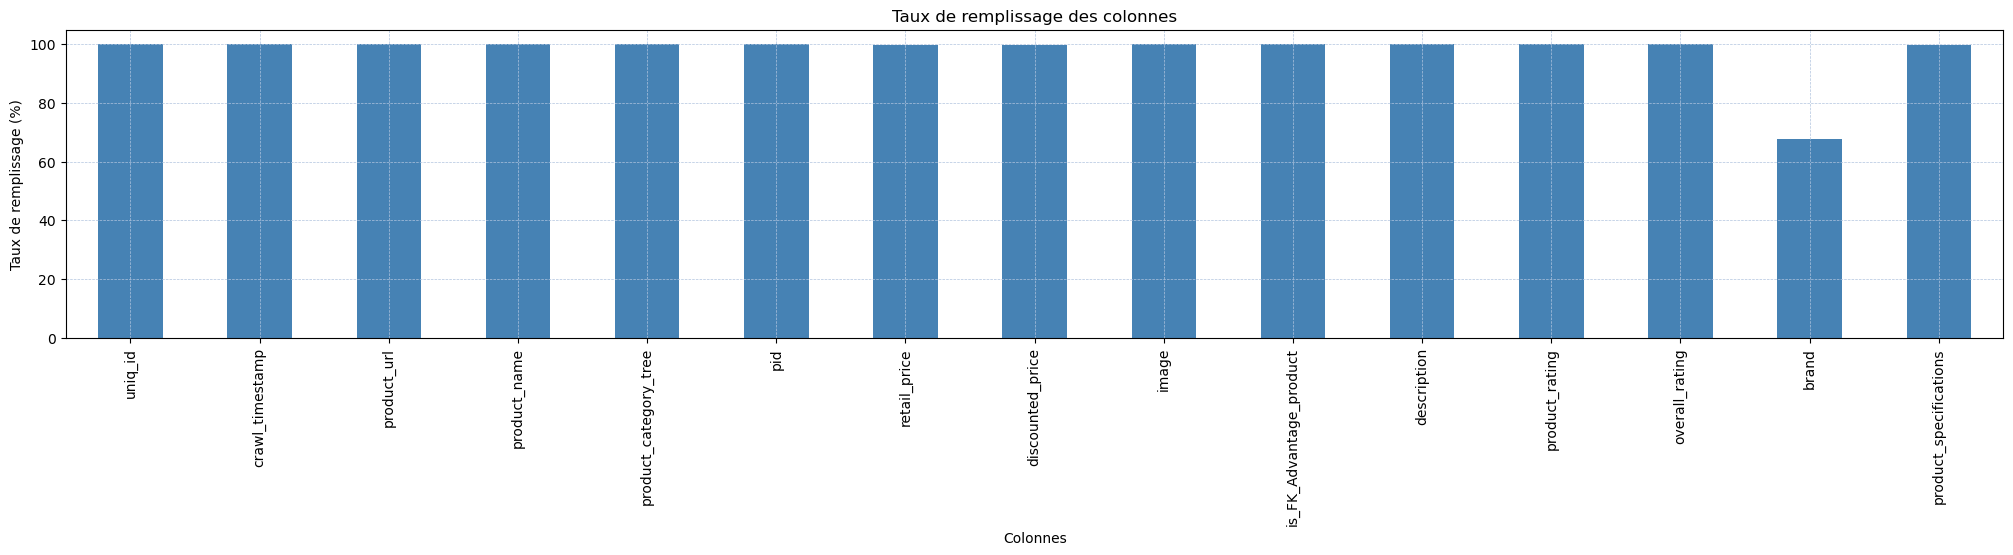

In [12]:
fill_rates_plot(raw_data)

- Doublons

In [13]:
raw_data.duplicated().sum()

0

- Modification des types

In [14]:
raw_data['crawl_timestamp'] = pd.to_datetime(raw_data['crawl_timestamp'])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   uniq_id                  1050 non-null   object             
 1   crawl_timestamp          1050 non-null   datetime64[ns, UTC]
 2   product_url              1050 non-null   object             
 3   product_name             1050 non-null   object             
 4   product_category_tree    1050 non-null   object             
 5   pid                      1050 non-null   object             
 6   retail_price             1049 non-null   float64            
 7   discounted_price         1049 non-null   float64            
 8   image                    1050 non-null   object             
 9   is_FK_Advantage_product  1050 non-null   bool               
 10  description              1050 non-null   object             
 11  product_rating           1050 

- Organisation des catégories

In [15]:
raw_data[['product_category_tree']]

,product_category_tree
0,"[""Home Furnishing >> Curtains & Accessories >>..."
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


In [16]:
df_category = raw_data.copy()

def categ(data):
    categ=[]
    for i in data:
        if i == ">": break
        if  i == "[":continue
        if  i == '''"''':continue
        if  i == "&":continue
        categ.append(i)
    categ ="".join(categ).strip()
    return categ

df_category['category']=df_category['product_category_tree'].apply(categ)
n_cat = df_category['product_category_tree'].str.count(">>").max()

for i in range(1, n_cat) :
  df_category['sub_category_%i' %i]=df_category['product_category_tree'].str.split('>>', expand=True)[i]
  df_category['sub_category_%i' %i] = df_category['sub_category_%i' %i].str.replace(r'(^.*].*$)', 'None')
  df_category['sub_category_%i' %i] = df_category['sub_category_%i' %i].str.replace(" '", '')

In [17]:
df_category.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,product_rating,overall_rating,brand,product_specifications,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,sub_category_5
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None


In [18]:
print('category  : ',df_category['category'].unique().size)
print('sub_category_1 : ',  df_category['sub_category_1'].unique().size)
print('sub_category_2 : ',  df_category['sub_category_2'].unique().size)
print('sub_category_3 : ',  df_category['sub_category_3'].unique().size)
print('sub_category_4 : ',  df_category['sub_category_4'].unique().size)
print('sub_category_5 : ',  df_category['sub_category_5'].unique().size)
df_category['category'].unique()


category  :  7
sub_category_1 :  63
sub_category_2 :  247
sub_category_3 :  351
sub_category_4 :  298
sub_category_5 :  118


array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor  Festive Needs', 'Kitchen  Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [19]:
df_category['category_id']=''
def assign_cluster(df):
  df.loc[df.eval("category == 'Baby Care'"), "category_id"]=0
  df.loc[df.eval("category == 'Beauty and Personal Care'"), "category_id"]=1
  df.loc[df.eval("category == 'Computers'"), "category_id"]=2
  df.loc[df.eval("category == 'Home Decor  Festive Needs'"), "category_id"]=3
  df.loc[df.eval("category == 'Home Furnishing'"), "category_id"]=4
  df.loc[df.eval("category == 'Kitchen  Dining'"), "category_id"]=5
  df.loc[df.eval("category == 'Watches'"), "category_id"]=6
  return df
assign_cluster(df_category)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,sub_category_5,category_id
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43+00:00,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,"Oren Empower Stickers""]",None,None,0
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43+00:00,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,...,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,"Wallmantra Stickers""]",None,None,0
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43+00:00,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb

In [20]:
df_category.groupby("category").agg({"uniq_id" : "count"}).reset_index()

,category,uniq_id
0,Baby Care,150
1,Beauty and Personal Care,150
2,Computers,150
3,Home Decor Festive Needs,150
4,Home Furnishing,150
5,Kitchen Dining,150
6,Watches,150


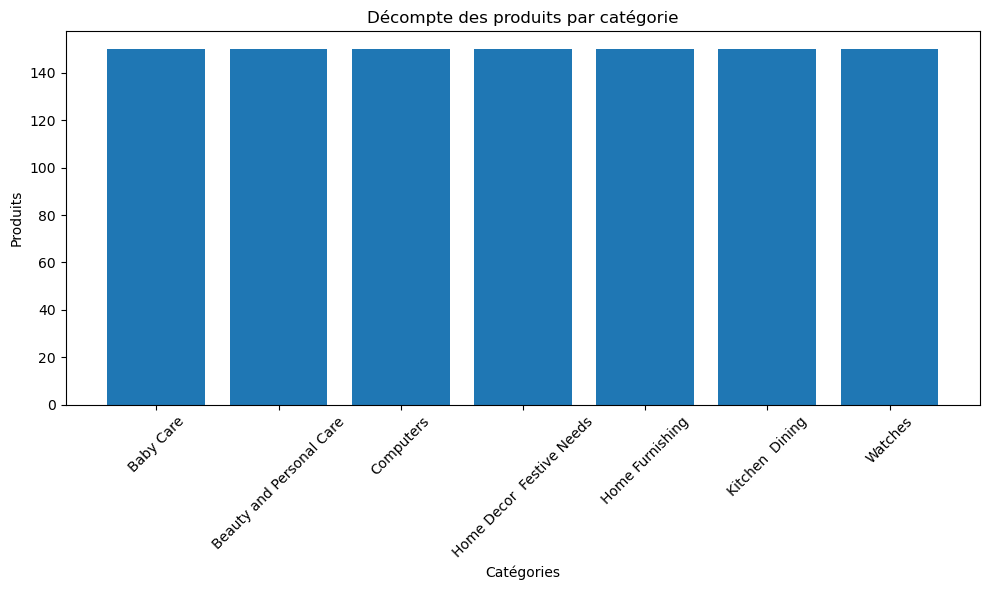

In [21]:
grouped_df = df_category.groupby("category").agg({"uniq_id": "count"}).reset_index()
grouped_df = grouped_df.rename(columns={"uniq_id": "count"})

plt.figure(figsize=(10, 6))
plt.bar(grouped_df["category"], grouped_df["count"])

plt.xlabel("Catégories")
plt.ylabel("Produits")
plt.title("Décompte des produits par catégorie")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [22]:
df_category.to_csv('./df_category.csv', index=False)

## <a name="C4"> Segmentation des produits via leurs description</a>

### Nettoyage du texte

- Mappage de la balise Part Of Speech

In [23]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

- Lemmatisation

Convertit le texte en minuscules  
Supprime les balises HTML ou XML (comme "{html}")  
Supprime les URL (liens web)  
Supprime les chiffres  
Divise le texte en tokens  
Filtre les mots courts et les stopwords (mots courants)  
Filtre sur les noms et les verbes  
Lemmatise les mots en utilisant WordNet (en fonction de leur partie du discours)

In [24]:
lemmatizer = WordNetLemmatizer()
wnl = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]\w+\'?\w*')
stop_words = set(nltk_stopwords.words("english"))

def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}', "")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '', cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'[a-zA-Z]\w+\'?\w*')
    tokens = tokenizer.tokenize(rem_num)
    tagged_words = nltk.pos_tag(tokens)
    filtered_words = [w for w, pos in tagged_words if len(w) > 2 and (pos.startswith('N') or pos.startswith('V')) and w not in stop_words]
    lemma_words = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    return " ".join(lemma_words)

df_category['lemmatizer_cat'] = df_category['description'].apply(preprocess)

In [25]:
df_category['lemmatizer_cat'].values[0]

'feature elegance polyester multicolor eyelet door curtain curtain elegance polyester multicolor eyelet door curtain pack price curtain enhances look interior curtain make quality polyester fabric feature eyelet style stitch metal ring make room environment love curtain wrinkle shrinkage apparance give home bright appeal design attention steal heart eyelet valance curtain slide draw thing morning welcome sun ray want wish morning world draw even create moment beauty give print bring home curtain filter room get amount specification elegance polyester multicolor eyelet door curtain pack brand elegance design door type eyelet model name polyester door curtain set model duster color multicolor dimension length box number content sale package pack sale package curtain material polyester'

In [26]:
df_category['tokenize_cat'] = df_category.apply(lambda x : w_tokenizer.tokenize(x['lemmatizer_cat']), axis = 1)
df_category['tokenize_cat'].values[0]

['feature',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'make',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'love',
 'curtain',
 'wrinkle',
 'shrinkage',
 'apparance',
 'give',
 'home',
 'bright',
 'appeal',
 'design',
 'attention',
 'steal',
 'heart',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'draw',
 'thing',
 'morning',
 'welcome',
 'sun',
 'ray',
 'want',
 'wish',
 'morning',
 'world',
 'draw',
 'even',
 'create',
 'moment',
 'beauty',
 'give',
 'print',
 'bring',
 'home',
 'curtain',
 'filter',
 'room',
 'get',
 'amount',
 'specification',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'brand',
 'elegance',
 'design',
 'door',
 'type',
 'eyelet',
 'model',
 'n

In [27]:
df_category['lemmatizer_name'] = df_category['product_name'].apply(preprocess)
df_category['lemmatizer_name'].values[0]

'elegance polyester multicolor eyelet door curtain'

In [28]:
df_category['tokenize_name'] = df_category.apply(lambda x : w_tokenizer.tokenize(x['lemmatizer_name']), axis = 1)
df_category['tokenize_name'].values[0]

['elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain']

In [29]:
df_category['tokenize_name'] = df_category['tokenize_name'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_category['tokenize_cat'] = df_category['tokenize_cat'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_category['tokenize'] = df_category['tokenize_name'] + ' ' + df_category['tokenize_cat']
df_category['tokenize'].values[0]

'elegance polyester multicolor eyelet door curtain feature elegance polyester multicolor eyelet door curtain curtain elegance polyester multicolor eyelet door curtain pack price curtain enhances look interior curtain make quality polyester fabric feature eyelet style stitch metal ring make room environment love curtain wrinkle shrinkage apparance give home bright appeal design attention steal heart eyelet valance curtain slide draw thing morning welcome sun ray want wish morning world draw even create moment beauty give print bring home curtain filter room get amount specification elegance polyester multicolor eyelet door curtain pack brand elegance design door type eyelet model name polyester door curtain set model duster color multicolor dimension length box number content sale package pack sale package curtain material polyester'

In [30]:
df_category['tokenize'] = df_category.apply(lambda x : w_tokenizer.tokenize(x['lemmatizer_cat']), axis = 1)
df_category['tokenize'].values[0]

['feature',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'make',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'love',
 'curtain',
 'wrinkle',
 'shrinkage',
 'apparance',
 'give',
 'home',
 'bright',
 'appeal',
 'design',
 'attention',
 'steal',
 'heart',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'draw',
 'thing',
 'morning',
 'welcome',
 'sun',
 'ray',
 'want',
 'wish',
 'morning',
 'world',
 'draw',
 'even',
 'create',
 'moment',
 'beauty',
 'give',
 'print',
 'bring',
 'home',
 'curtain',
 'filter',
 'room',
 'get',
 'amount',
 'specification',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'brand',
 'elegance',
 'design',
 'door',
 'type',
 'eyelet',
 'model',
 'n

- Décompte des mots 

In [31]:
text_total = []
for i in range(len(df_category['tokenize'])) : 
  text_total += df_category['tokenize'].values[i]
print('Nombre de mots de la colonne tokenize : ', len(text_total))
print('Nombre de mots UNIQUES de la colonne tokenize : ', len(set(text_total)))

Nombre de mots de la colonne tokenize :  39940
Nombre de mots UNIQUES de la colonne tokenize :  3408



## <a name="C4"> Numérisation du texte, méthode Frequentiste</a>

- Count Vectorizer

In [32]:
count_vec = CountVectorizer()
df_category['tokenize_text'] = df_category['tokenize'].apply(' '.join)
x = count_vec.fit_transform(df_category['tokenize_text'])
df_count_vec = pd.DataFrame(x.toarray(), columns=count_vec.get_feature_names_out())
df_count_vec

,aapno,aari,ability,abkl_grn_grn_grn,abkl_pl_pl_pnk,abkl_pl_pnk_pnk,abode,abrasion,absolute,absorb,...,zaicus,zero,zinc,zingalalaa,zip,zipper,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Séparation des données 

In [33]:
print("Dimensions dataset avant réduction PCA : ", df_count_vec.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(df_count_vec)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print("Dimensions dataset avec 2 dimensions de la composante TSNE : ",df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1050, 3395)
Dimensions dataset après réduction PCA :  (1050, 509)
Dimensions dataset avec 2 dimensions de la composante TSNE :  (1050, 2)


- Segmentation

In [34]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=9)
kmeans.fit_transform(df_tsne)
df_tsne['class'] = kmeans.labels_

In [35]:
df_category

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,sub_category_3,sub_category_4,sub_category_5,category_id,lemmatizer_cat,tokenize_cat,lemmatizer_name,tokenize_name,tokenize,tokenize_text
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance Polyester Multicolor Abstract Eyelet...,None,None,4,feature elegance polyester multicolor eyelet d...,feature elegance polyester multicolor eyelet d...,elegance polyester multicolor eyelet door curtain,elegance polyester multicolor eyelet door curtain,"[feature, elegance, polyester, multicolor, eye...",feature elegance polyester multicolor eyelet d...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,0,specification cotton bath towel bath towel red...,specification cotton bath towel bath towel red...,cotton bath towel,cotton bath towel,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,0,feature cotton terry face towel set size heigh...,feature cotton terry face towel set size heigh...,cotton terry face towel set,cotton terry face towel set,"[feature, cotton, terry, face, towel, set, siz...",feature cotton terry face towel set size heigh...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,4,feature fashion cotton print king size bedshee...,feature fashion cotton print king size bedshee...,fashion cotton print king size bedsheet,fashion cotton print king size bedsheet,"[feature, fashion, cotton, print, king, size, ...",feature fashion cotton print king size bedshee...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,4,feature jaipur print cotton king size bedsheet...,feature jaipur print cotton king size bedsheet...,jaipur print cotton king size bedsheet,jaipur print cotton king size bedsheet,"[feature, jaipur, print, cotton, king, size, b...",feature jaipur print cotton king size bedsheet...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43+00:00,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,"Oren Empower Stickers""]",None,None,0,oren empower self sticker pack price sticker u...,oren empower self sticker pack price sticker u...,oren empower self sticker,oren empower

In [36]:
df_tsne["category_id"] = df_category['category_id']
category_mapping = {0: "Baby Care",1: "Beauty and Personal Care",2: "Computers",3: "Home Decor & Festive Needs",
                    4: "Home Furnishing",5: "Kitchen & Dining",6: "Watches"}
df_tsne['Category_name'] = df_tsne['category_id'].map(category_mapping)
df_tsne

,tsne1,tsne2,class,category_id,Category_name
0,-18.874428,-21.371643,5,4,Home Furnishing
1,5.871829,-26.618795,3,0,Baby Care
2,8.615097,-26.193050,3,0,Baby Care
3,-9.241138,-29.255907,3,4,Home Furnishing
4,-9.829008,-28.806147,3,4,Home Furnishing
...,...,...,...,...,...
1045,10.921546,-2.431478,1,0,Baby Care
1046,17.320358,14.890594,1,0,Baby Care
1047,14.476790,16.477100,1,0,Baby Care
1048,16.210400,14.112265,1,0,Baby Care


- Visualisation

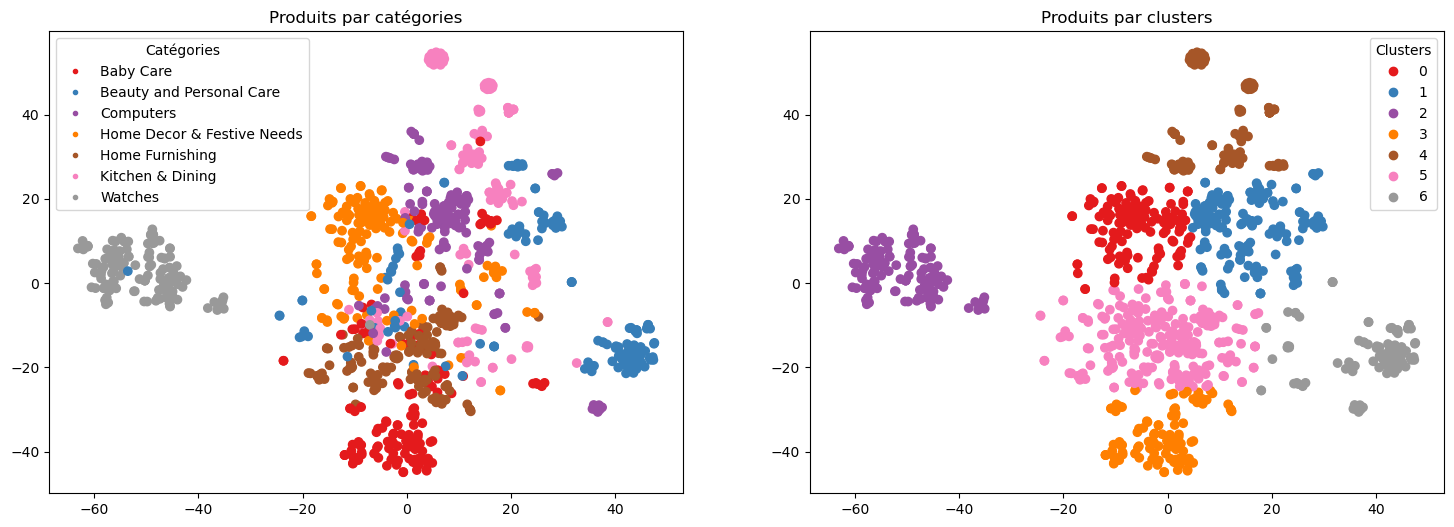

In [37]:
plt.figure(figsize=(18, 6))
category_names = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs",
                  "Home Furnishing","Kitchen & Dining","Watches"]

plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [38]:
manual_mapping = {2: 0,3: 1,1: 2,6: 3,5: 4,4: 5,0: 6}
df_tsne['class_renamed'] = df_tsne['class'].map(manual_mapping)

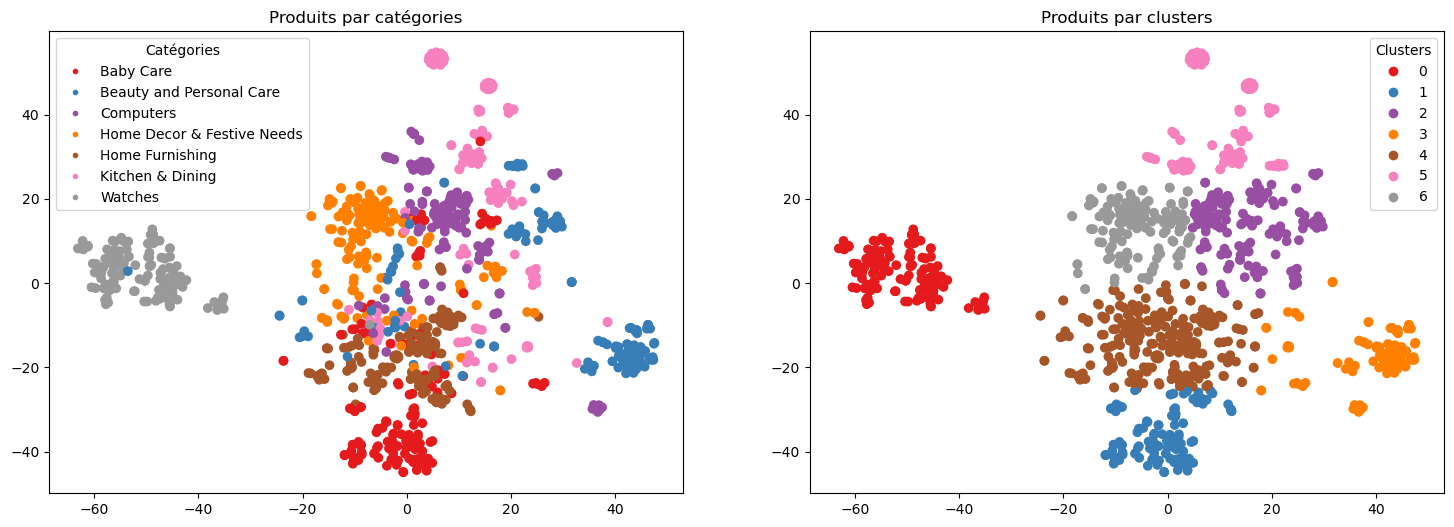

In [39]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class_renamed'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

- Score ARI

In [40]:
print('ARI score: ',adjusted_rand_score(df_tsne['class_renamed'], df_tsne['category_id']))

ARI score:  0.3982475634508743


- Analyse des catégories

In [41]:
df_tsne.groupby("class_renamed").count()

,tsne1,tsne2,class,category_id,Category_name
class_renamed,,,,,
0,150,150,150,150,150
1,111,111,111,111,111
2,173,173,173,173,173
3,106,106,106,106,106
4,264,264,264,264,264
5,111,111,111,111,111
6,135,135,135,135,135


In [42]:
def calculate_confusion_matrix(y_true, y_pred):
    categories = ["Baby Care", "Beauty and Personal Care", "Computers","Home Decor & Festive Needs", 
                  "Home Furnishing","Kitchen & Dining", "Watches"]
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, index=[f'Actual {categories[i]}' for i in range(len(conf_mat))],
                               columns=[f'Predicted {categories[i]}' for i in range(len(conf_mat[0]))])
    classification_report = metrics.classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(classification_report).transpose()
    return conf_mat_df, class_report_df

In [43]:
df_tsne['category_id'] = df_tsne['category_id'].astype(int)
df_tsne['class_renamed'] = df_tsne['class_renamed'].astype(int)
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(df_tsne['category_id'], df_tsne['class_renamed'])

print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


,Predicted Baby Care,Predicted Beauty and Personal Care,Predicted Computers,Predicted Home Decor & Festive Needs,Predicted Home Furnishing,Predicted Kitchen & Dining,Predicted Watches
Actual Baby Care,0,93,10,7,31,1,8
Actual Beauty and Personal Care,1,0,32,72,28,7,10
Actual Computers,0,0,75,12,21,29,13
Actual Home Decor & Festive Needs,0,0,14,5,29,0,102
Actual Home Furnishing,0,18,4,1,127,0,0
Actual Kitchen & Dining,0,0,38,9,27,74,2
Actual Watches,149,0,0,0,1,0,0


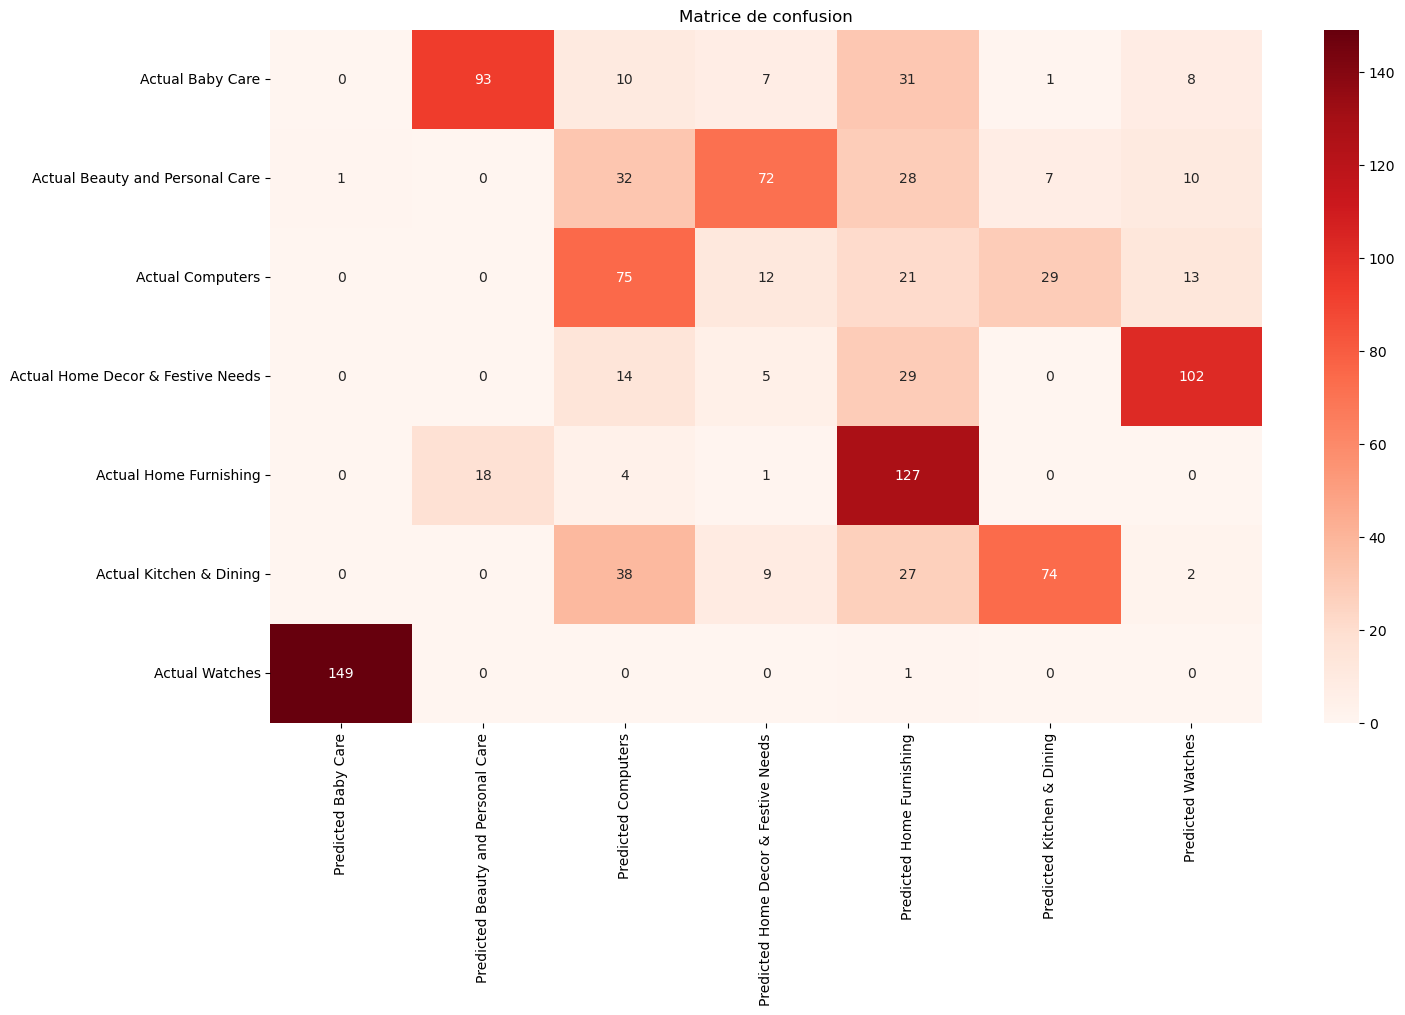

Rapport de classification :


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,150.000000
1,0.000000,0.000000,0.000000,150.000000
2,0.433526,0.500000,0.464396,150.000000
3,0.047170,0.033333,0.039062,150.000000
4,0.481061,0.846667,0.613527,150.000000
5,0.666667,0.493333,0.567050,150.000000
6,0.000000,0.000000,0.000000,150.000000
accuracy,0.267619,0.267619,0.267619,0.267619
macro avg,0.232632,0.267619,0.240576,1050.000000
weighted avg,0.232632,0.267619,0.240576,1050.000000


In [44]:
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap="Reds") # fmt='d' pour afficher des entiers
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

- TF-IDF avec LDA

In [45]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_category['tokenize_text'])
print(len(tfidf.vocabulary_))
df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf

3395


,aapno,aari,ability,abkl_grn_grn_grn,abkl_pl_pl_pnk,abkl_pl_pnk_pnk,abode,abrasion,absolute,absorb,...,zaicus,zero,zinc,zingalalaa,zip,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
print("Dimensions dataset avant réduction LDA : ", df_tfidf.shape)
lda = LatentDirichletAllocation(n_components=50, random_state=42)
feat_lda = lda.fit_transform(df_tfidf)
print("Dimensions dataset après réduction LDA : ", feat_lda.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_lda)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

Dimensions dataset avant réduction LDA :  (1050, 3395)
Dimensions dataset après réduction LDA :  (1050, 50)
(1050, 2)


In [47]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=9)
kmeans.fit_transform(df_tsne)
df_tsne['class'] = kmeans.labels_
df_tsne["category_id"] = df_category['category_id']

category_mapping = {0: "Baby Care",1: "Beauty and Personal Care",2: "Computers",3: "Home Decor & Festive Needs",
                    4: "Home Furnishing",5: "Kitchen & Dining",6: "Watches"}

df_tsne['Category_name'] = df_tsne['category_id'].map(category_mapping)
df_tsne

,tsne1,tsne2,class,category_id,Category_name
0,-3.732176,-30.265841,4,4,Home Furnishing
1,-10.010604,-5.443848,0,0,Baby Care
2,3.793306,-15.472804,0,0,Baby Care
3,1.202012,-5.093056,0,4,Home Furnishing
4,0.780106,-5.428889,0,4,Home Furnishing
...,...,...,...,...,...
1045,-20.658602,10.304335,5,0,Baby Care
1046,15.455708,-23.337000,0,0,Baby Care
1047,-50.257420,-15.692055,6,0,Baby Care
1048,9.907686,35.587296,3,0,Baby Care


In [48]:
print('ARI score: ',adjusted_rand_score(df_tsne['class'], df_tsne['category_id']))

ARI score:  0.1804014906810727


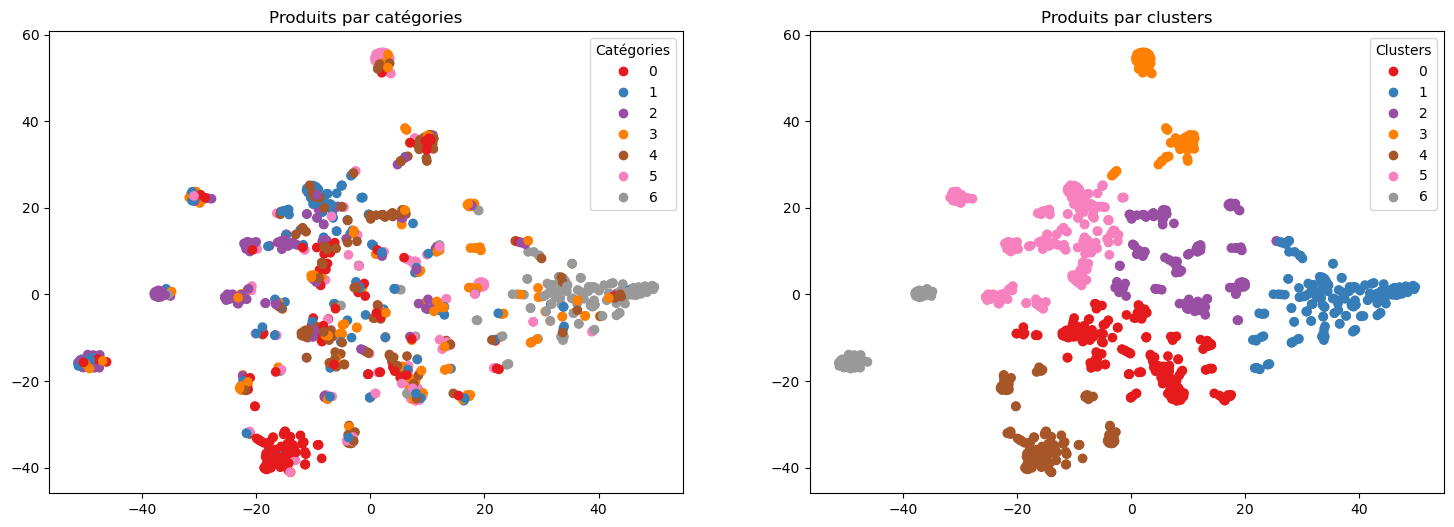

In [49]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap='Set1')
plt.title('Produits par catégories')
plt.legend(*scatter.legend_elements(), title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

## <a name="C4"> Numérisation du texte, méthode Embedding</a>

- Word2Vec

In [50]:
df_category['word_count'] = df_category['tokenize'].apply(len)
average_word_count = df_category['word_count'].mean()
average_word_count

38.03809523809524

In [51]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=50
maxlen = 38 
sentences = df_category['tokenize'].to_list()

In [52]:
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,vector_size=w2v_size,seed=42,workers=1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3408
Word2Vec trained


In [53]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),maxlen=maxlen,padding='post')                                                  
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3409


- Création de la matrice d'embedding

In [54]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0 
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3409, 300)


In [55]:
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,output_dim=w2v_size,weights = [embedding_matrix],input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)
embed_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 38, 300)        │     1,022,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,700 (3.90 MB)

 Trainable params: 1,022,700 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

- Modélisation

In [56]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


(1050, 300)

- PCA TSNE KMEANS

In [57]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30,n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(embeddings)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 26)
(1050, 2)


In [58]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=9)
kmeans.fit_transform(df_tsne)

array([[61.81508 , 15.565333, 42.829823, ..., 91.917595, 73.13952 ,
        18.31015 ],
       [58.434277, 16.300505, 39.084805, ..., 88.714264, 69.35933 ,
        14.452431],
       [58.669865, 15.948475, 39.038353, ..., 88.97005 , 69.5144  ,
        14.585874],
       ...,
       [16.87646 , 70.20898 , 34.52975 , ..., 38.99054 ,  9.331728,
        45.64239 ],
       [18.411674, 69.832855, 33.50593 , ..., 40.340485,  9.676409,
        45.55428 ],
       [16.680832, 70.042046, 34.466328, ..., 38.984814,  9.52095 ,
        45.44479 ]], dtype=float32)

In [59]:
df_tsne['class'] = kmeans.labels_

In [60]:
df_tsne["category_id"] = df_category['category_id']
category_mapping = {0: "Baby Care",1: "Beauty and Personal Care",2: "Computers",3: "Home Decor & Festive Needs",
                    4: "Home Furnishing",5: "Kitchen & Dining",6: "Watches"}
df_tsne['Category_name'] = df_tsne['category_id'].map(category_mapping)
df_tsne

,tsne1,tsne2,class,category_id,Category_name
0,33.383778,-11.164830,1,4,Home Furnishing
1,30.198772,-8.883830,6,0,Baby Care
2,30.453091,-8.635886,6,0,Baby Care
3,39.242714,-8.454325,1,4,Home Furnishing
4,38.840858,-8.914087,1,4,Home Furnishing
...,...,...,...,...,...
1045,10.220164,7.965800,6,0,Baby Care
1046,11.179386,7.811956,6,0,Baby Care
1047,-26.013313,12.254283,5,0,Baby Care
1048,-25.374260,13.716857,5,0,Baby Care


- Visualisation

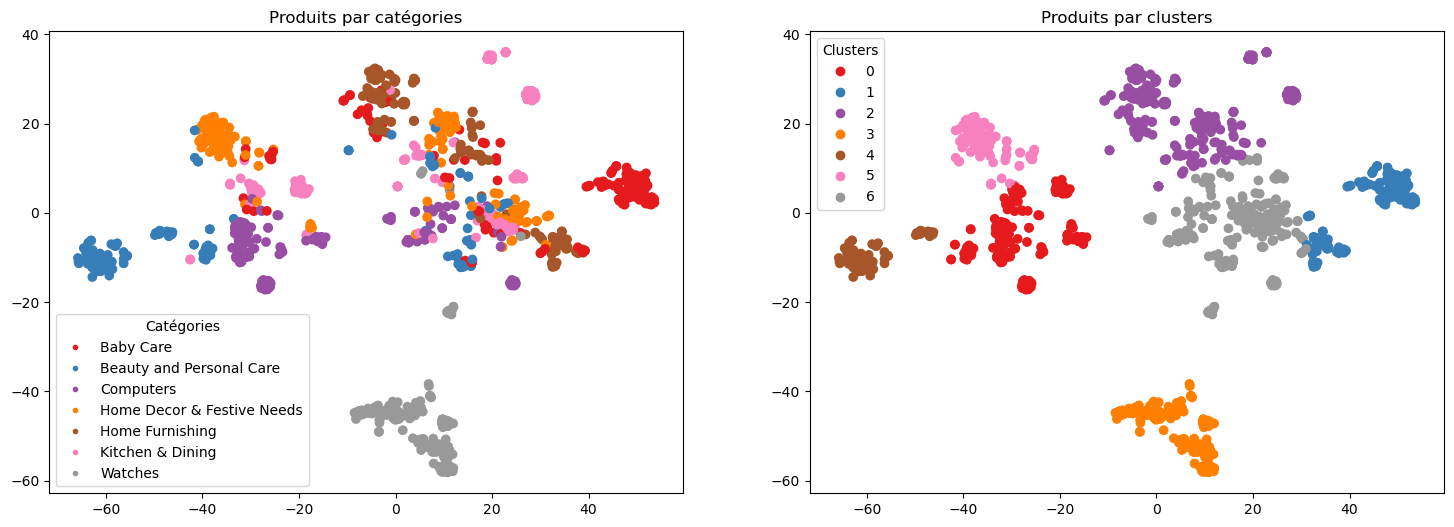

In [61]:
plt.figure(figsize=(18, 6))
category_names = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing",
                  "Kitchen & Dining","Watches"]

plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [62]:
manual_mapping = {1: 0,5: 1,0: 2,6: 3, 3: 4,4: 5,2: 6}
df_tsne['class_renamed'] = df_tsne['class'].map(manual_mapping)


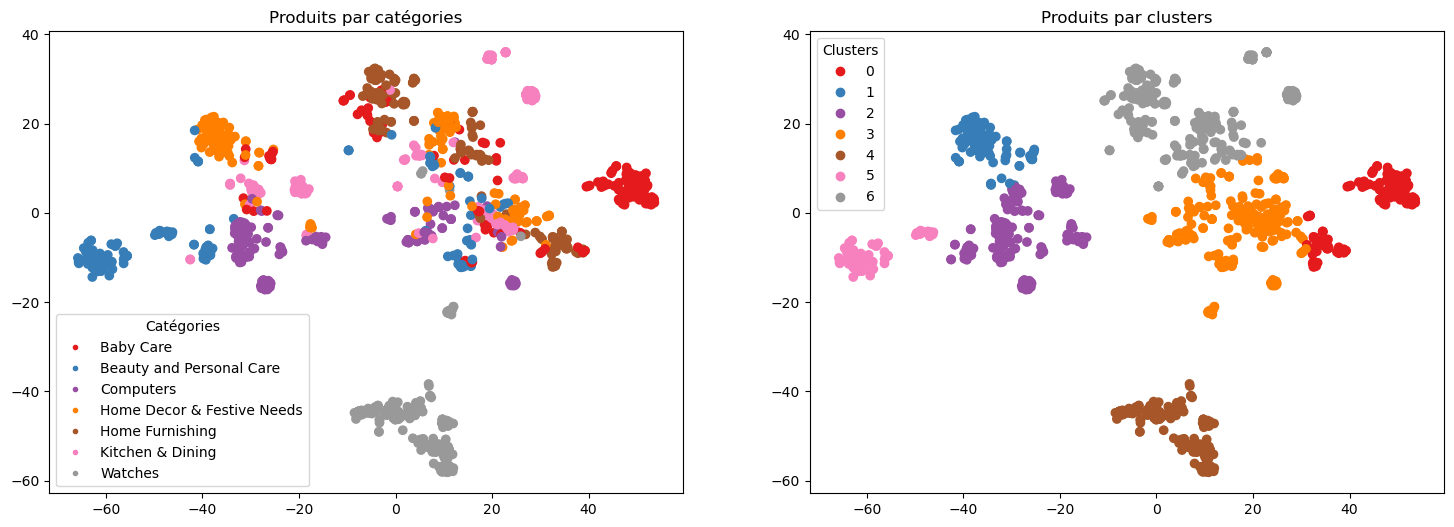

In [63]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))

scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class_renamed'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [64]:
print('ARI score: ',adjusted_rand_score(df_tsne['class_renamed'], df_tsne['category_id']))

ARI score:  0.31960104517353943


- Analyse des catégories

In [65]:
df_tsne.groupby("class_renamed").count()

,tsne1,tsne2,class,category_id,Category_name
class_renamed,,,,,
0,121,121,121,121,121
1,92,92,92,92,92
2,167,167,167,167,167
3,215,215,215,215,215
4,136,136,136,136,136
5,76,76,76,76,76
6,243,243,243,243,243


In [66]:
df_tsne['category_id'] = df_tsne['category_id'].astype(int)
df_tsne['class_renamed'] = df_tsne['class_renamed'].astype(int)
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(df_tsne['category_id'], df_tsne['class_renamed'])
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


,Predicted Baby Care,Predicted Beauty and Personal Care,Predicted Computers,Predicted Home Decor & Festive Needs,Predicted Home Furnishing,Predicted Kitchen & Dining,Predicted Watches
Actual Baby Care,81,10,4,21,0,0,34
Actual Beauty and Personal Care,0,5,20,38,0,76,11
Actual Computers,0,0,94,55,0,0,1
Actual Home Decor & Festive Needs,5,68,8,36,0,0,33
Actual Home Furnishing,35,0,0,15,0,0,100
Actual Kitchen & Dining,0,9,41,39,0,0,61
Actual Watches,0,0,0,11,136,0,3


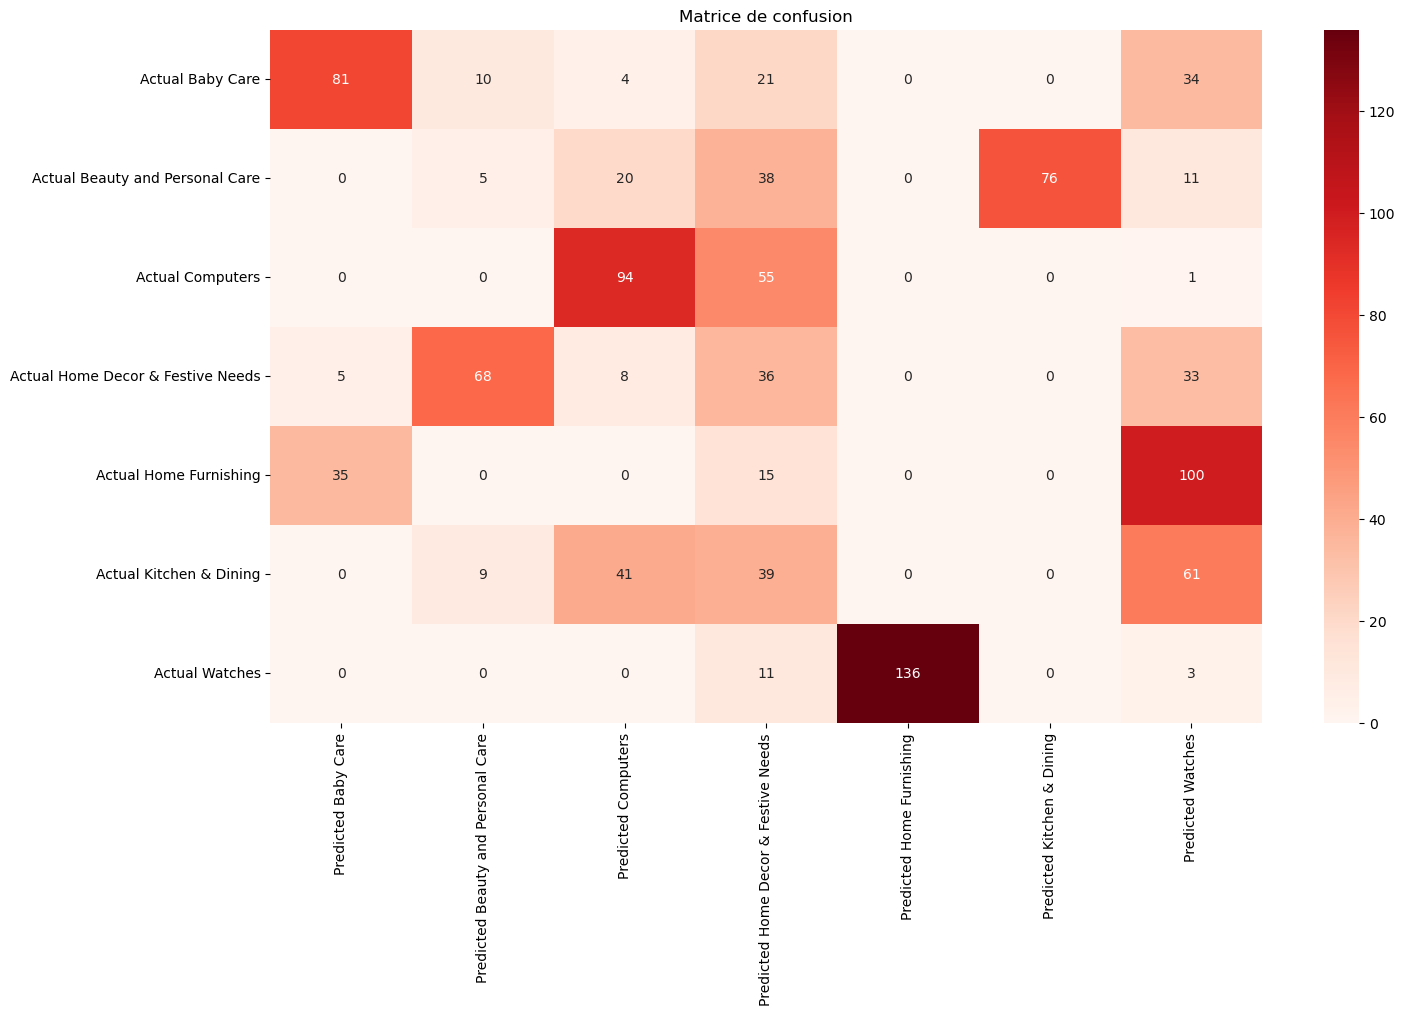

Rapport de classification :


,precision,recall,f1-score,support
0,0.669421,0.540000,0.597786,150.000000
1,0.054348,0.033333,0.041322,150.000000
2,0.562874,0.626667,0.593060,150.000000
3,0.167442,0.240000,0.197260,150.000000
4,0.000000,0.000000,0.000000,150.000000
5,0.000000,0.000000,0.000000,150.000000
6,0.012346,0.020000,0.015267,150.000000
accuracy,0.208571,0.208571,0.208571,0.208571
macro avg,0.209490,0.208571,0.206385,1050.000000
weighted avg,0.209490,0.208571,0.206385,1050.000000


In [67]:
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap="Reds") 
plt.title('Matrice de confusion')
plt.show()
print("Rapport de classification :")
classification_report_df

- BERT

In [68]:
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = max_length,
                                              padding='max_length',return_attention_mask = True, 
                                              return_token_type_ids=True,truncation=True,return_tensors="tf")
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    all_last_hidden_states = []

    for step in range(0, len(sentences), batch_size):
        batch_sentences = sentences[step:step + batch_size]
        input_ids, token_type_ids, attention_mask, _ = bert_inp_fct(batch_sentences, bert_tokenizer, max_length)

        if mode == 'HF':
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_hidden_states = outputs.last_hidden_state
            all_last_hidden_states.append(last_hidden_states)

        elif mode == 'TFhub':
            text_preprocessed = {"input_word_ids": input_ids, "input_mask": attention_mask, "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
            all_last_hidden_states.append(last_hidden_states.numpy())

    # Concaténation des états cachés et calcul des features
    last_hidden_states_tot = np.concatenate(all_last_hidden_states, axis=0)
    features_bert = last_hidden_states_tot.mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("Temps de traitement : ", time2)

    return features_bert, last_hidden_states_tot

- BERT Hugging Face

In [69]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFBertModel.from_pretrained(model_type)
sentences = df_category['tokenize'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [70]:
sentences[0]

['feature',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'make',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'love',
 'curtain',
 'wrinkle',
 'shrinkage',
 'apparance',
 'give',
 'home',
 'bright',
 'appeal',
 'design',
 'attention',
 'steal',
 'heart',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'draw',
 'thing',
 'morning',
 'welcome',
 'sun',
 'ray',
 'want',
 'wish',
 'morning',
 'world',
 'draw',
 'even',
 'create',
 'moment',
 'beauty',
 'give',
 'print',
 'bring',
 'home',
 'curtain',
 'filter',
 'room',
 'get',
 'amount',
 'specification',
 'elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'pack',
 'brand',
 'elegance',
 'design',
 'door',
 'type',
 'eyelet',
 'model',
 'n

In [71]:
sentences = [" ".join(sentence) if isinstance(sentence, list) else sentence for sentence in sentences]
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,max_length, batch_size, mode='HF')

Temps de traitement :  61.0


In [72]:
features_bert

array([[ 0.15496726, -0.19654211,  0.7929938 , ...,  0.05731631,
        -0.13482599, -0.10435491],
       [ 0.30524766, -0.15973765,  0.51239645, ..., -0.1513813 ,
        -0.12201816,  0.09283799],
       [ 0.20878297, -0.13084827,  0.63361907, ..., -0.14369455,
        -0.33562535,  0.16001031],
       ...,
       [ 0.30624202, -0.08272122,  0.31402844, ...,  0.11496041,
        -0.10710801, -0.18464501],
       [ 0.29634362, -0.1111225 ,  0.3049291 , ...,  0.30860233,
        -0.15018521, -0.29806823],
       [ 0.5129327 , -0.1639052 ,  0.15550944, ...,  0.16753887,
        -0.17819294, -0.31435257]], dtype=float32)

- PCA TSNE KMEANS

In [73]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(features_bert)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 284)
(1050, 2)


In [74]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=9)
kmeans.fit_transform(df_tsne)
df_tsne['class'] = kmeans.labels_
df_tsne["category_id"] = df_category['category_id']
category_mapping = {0: "Baby Care",1: "Beauty and Personal Care",2: "Computers",3: "Home Decor & Festive Needs",
                    4: "Home Furnishing",5: "Kitchen & Dining",6: "Watches"}
df_tsne['Category_name'] = df_tsne['category_id'].map(category_mapping)


- Visualisation

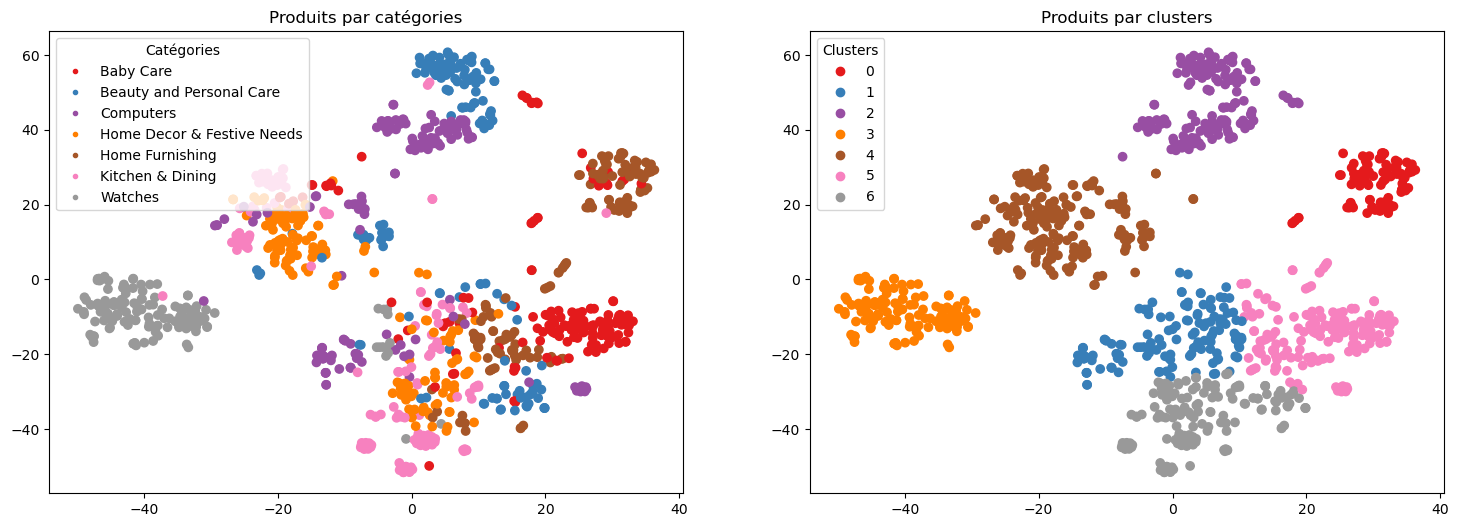

In [75]:
plt.figure(figsize=(18, 6))
category_names = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing",
                  "Kitchen & Dining","Watches"]

plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [76]:
manual_mapping = {4: 0,2: 1,1: 2,3: 3,6: 4,5: 5,0: 6}
df_tsne['class_renamed'] = df_tsne['class'].map(manual_mapping)


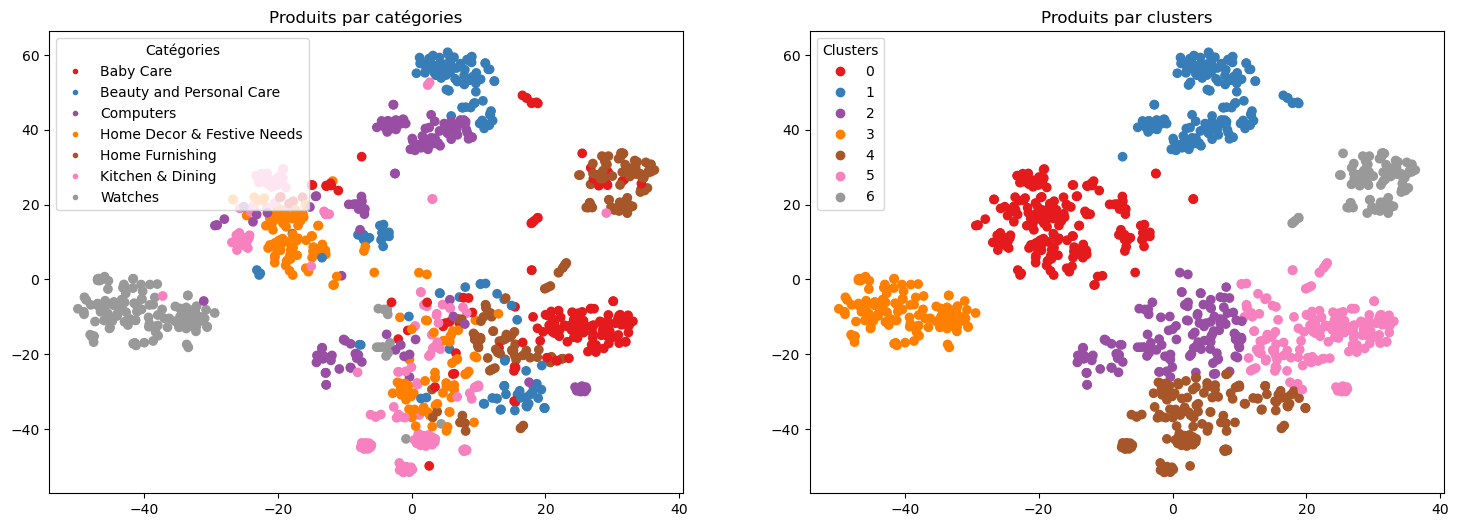

In [77]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")
plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class_renamed'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [78]:
print('ARI score: ',adjusted_rand_score(df_tsne['class_renamed'], df_tsne['category_id']))

ARI score:  0.329680333658856


- Analyse des catégories

In [79]:
df_tsne.groupby("class_renamed").count()

,tsne1,tsne2,class,category_id,Category_name
class_renamed,,,,,
0,195,195,195,195,195
1,160,160,160,160,160
2,139,139,139,139,139
3,137,137,137,137,137
4,157,157,157,157,157
5,169,169,169,169,169
6,93,93,93,93,93


In [80]:
df_tsne['category_id'] = df_tsne['category_id'].astype(int)
df_tsne['class_renamed'] = df_tsne['class_renamed'].astype(int)
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(df_tsne['category_id'], df_tsne['class_renamed'])
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


,Predicted Baby Care,Predicted Beauty and Personal Care,Predicted Computers,Predicted Home Decor & Festive Needs,Predicted Home Furnishing,Predicted Kitchen & Dining,Predicted Watches
Actual Baby Care,13,8,14,0,4,93,18
Actual Beauty and Personal Care,22,80,8,0,27,13,0
Actual Computers,25,70,43,1,0,11,0
Actual Home Decor & Festive Needs,85,0,22,0,42,1,0
Actual Home Furnishing,0,0,13,0,12,51,74
Actual Kitchen & Dining,50,2,26,1,70,0,1
Actual Watches,0,0,13,135,2,0,0


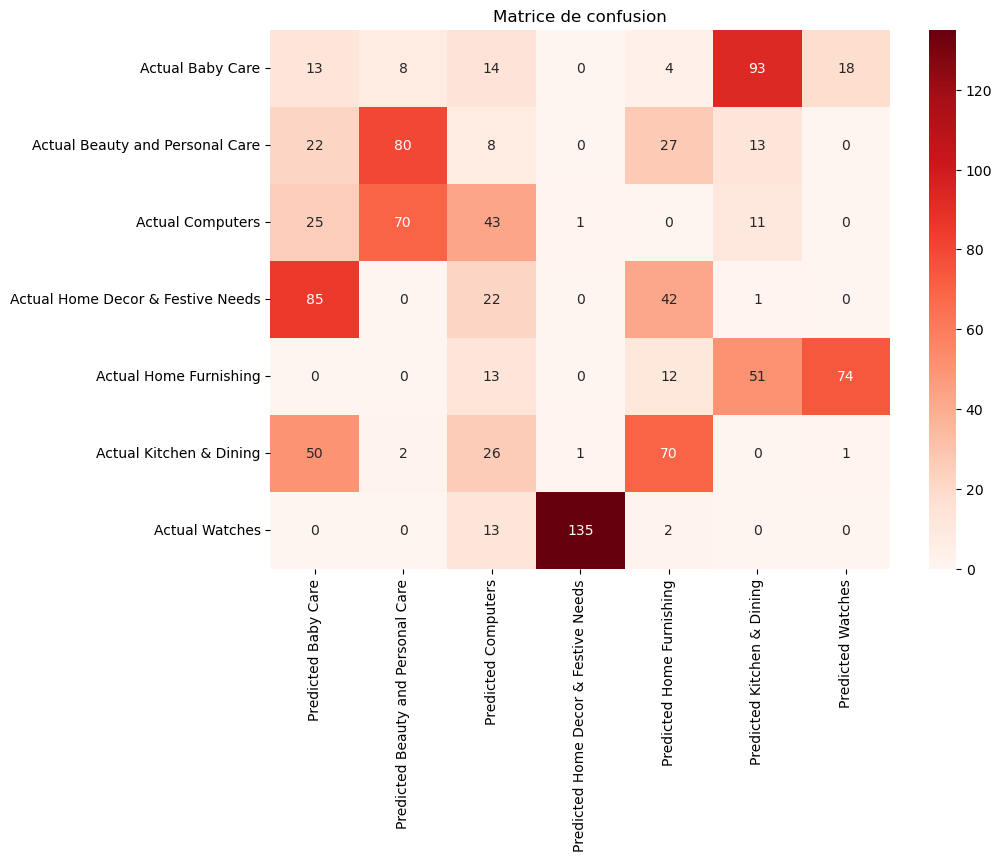

Rapport de classification :


,precision,recall,f1-score,support
0,0.066667,0.086667,0.075362,150.000000
1,0.500000,0.533333,0.516129,150.000000
2,0.309353,0.286667,0.297578,150.000000
3,0.000000,0.000000,0.000000,150.000000
4,0.076433,0.080000,0.078176,150.000000
5,0.000000,0.000000,0.000000,150.000000
6,0.000000,0.000000,0.000000,150.000000
accuracy,0.140952,0.140952,0.140952,0.140952
macro avg,0.136065,0.140952,0.138178,1050.000000
weighted avg,0.136065,0.140952,0.138178,1050.000000


In [81]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap="Reds") 
plt.title('Matrice de confusion')
plt.show()
print("Rapport de classification :")
classification_report_df

- USE

In [82]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

- Création des variables

In [83]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])
        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    time2 = np.round(time.time() - time1,0)
    return features

In [84]:
batch_size = 10
sentences = df_category['tokenize'].to_list()
sentences_transformed = [" ".join(sentence) for sentence in sentences]
features_USE = feature_USE_fct(sentences_transformed, batch_size)

- PCA TSNE KMEANS

In [85]:
print("Dimensions dataset avant réduction PCA : ", features_USE.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_USE)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 307)
(1050, 2)


In [86]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=100, random_state=9)
kmeans.fit_transform(df_tsne)
df_tsne['class'] = kmeans.labels_
df_tsne["category_id"] = df_category['category_id']
category_mapping = {0: "Baby Care",1: "Beauty and Personal Care",2: "Computers",3: "Home Decor & Festive Needs",
                    4: "Home Furnishing",5: "Kitchen & Dining",6: "Watches"}
df_tsne['Category_name'] = df_tsne['category_id'].map(category_mapping)


- Visualisation

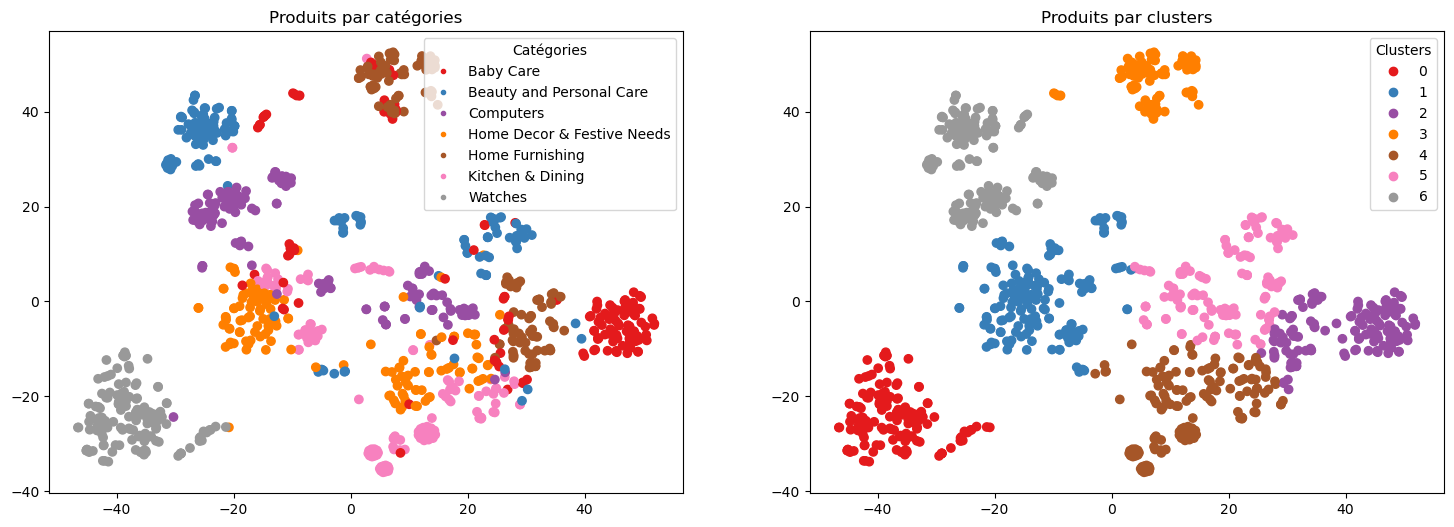

In [87]:
plt.figure(figsize=(18, 6))

category_names = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing",
                  "Kitchen & Dining","Watches"]

plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')

legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [88]:
manual_mapping = {5: 0,6: 1,2: 2,3: 3,4: 4,0: 5,1: 6}
df_tsne['class_renamed'] = df_tsne['class'].map(manual_mapping)

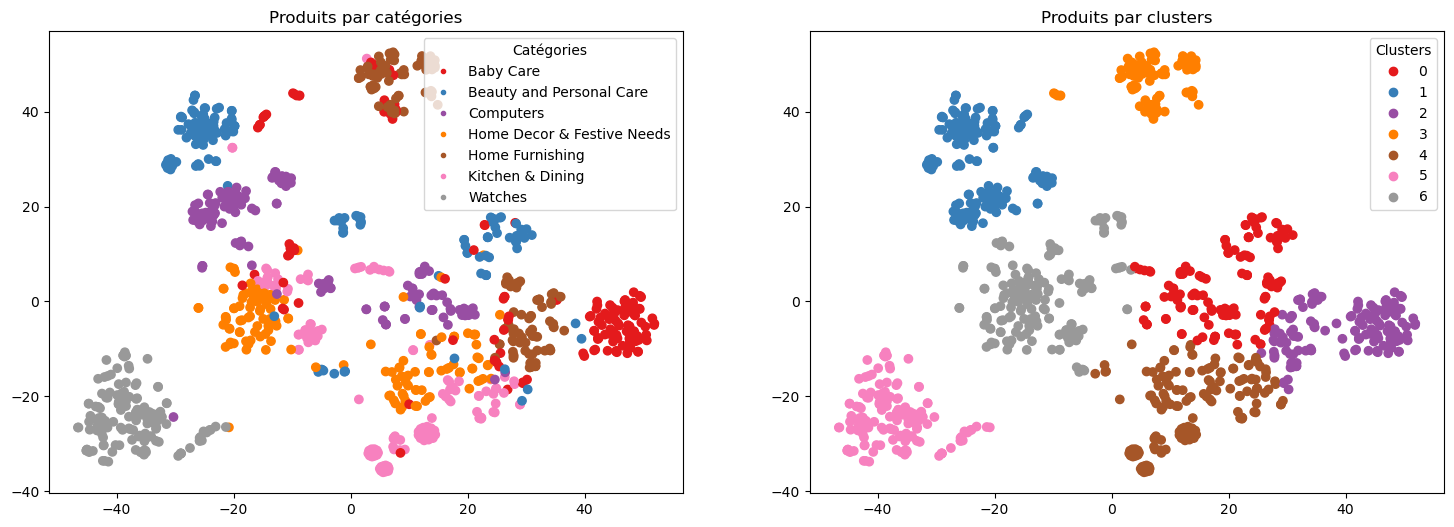

In [89]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
cmap = plt.get_cmap('Set1', len(category_names))
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['category_id'], cmap=cmap)
plt.title('Produits par catégories')
legend_handles = [plt.Line2D([0], [0], marker='.', color=cmap(i), linestyle='', label=category_names[i]) 
                  for i in range(len(category_names))]
plt.legend(handles=legend_handles, title="Catégories")

plt.subplot(122)
scatter = plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['class_renamed'], cmap='Set1')
plt.title('Produits par clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [90]:
print('ARI score: ',adjusted_rand_score(df_tsne['class_renamed'], df_tsne['category_id']))

ARI score:  0.3988111794238613


- Analyse des catégories

In [91]:
df_tsne.groupby("class_renamed").count()

,tsne1,tsne2,class,category_id,Category_name
class_renamed,,,,,
0,144,144,144,144,144
1,161,161,161,161,161
2,151,151,151,151,151
3,94,94,94,94,94
4,163,163,163,163,163
5,152,152,152,152,152
6,185,185,185,185,185


In [92]:
# Convertir les catégories réelles en entiers
df_tsne['category_id'] = df_tsne['category_id'].astype(int)

# Convertir les clusters prédits en entiers
df_tsne['class_renamed'] = df_tsne['class_renamed'].astype(int)

# Calculer la matrice de confusion et le rapport de classification
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(df_tsne['category_id'], df_tsne['class_renamed'])

# Afficher la matrice de confusion
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


,Predicted Baby Care,Predicted Beauty and Personal Care,Predicted Computers,Predicted Home Decor & Festive Needs,Predicted Home Furnishing,Predicted Kitchen & Dining,Predicted Watches
Actual Baby Care,14,7,91,18,6,0,14
Actual Beauty and Personal Care,40,80,3,0,6,0,21
Actual Computers,52,72,0,0,2,1,23
Actual Home Decor & Festive Needs,15,0,0,0,55,1,79
Actual Home Furnishing,17,0,57,75,1,0,0
Actual Kitchen & Dining,6,2,0,1,93,0,48
Actual Watches,0,0,0,0,0,150,0


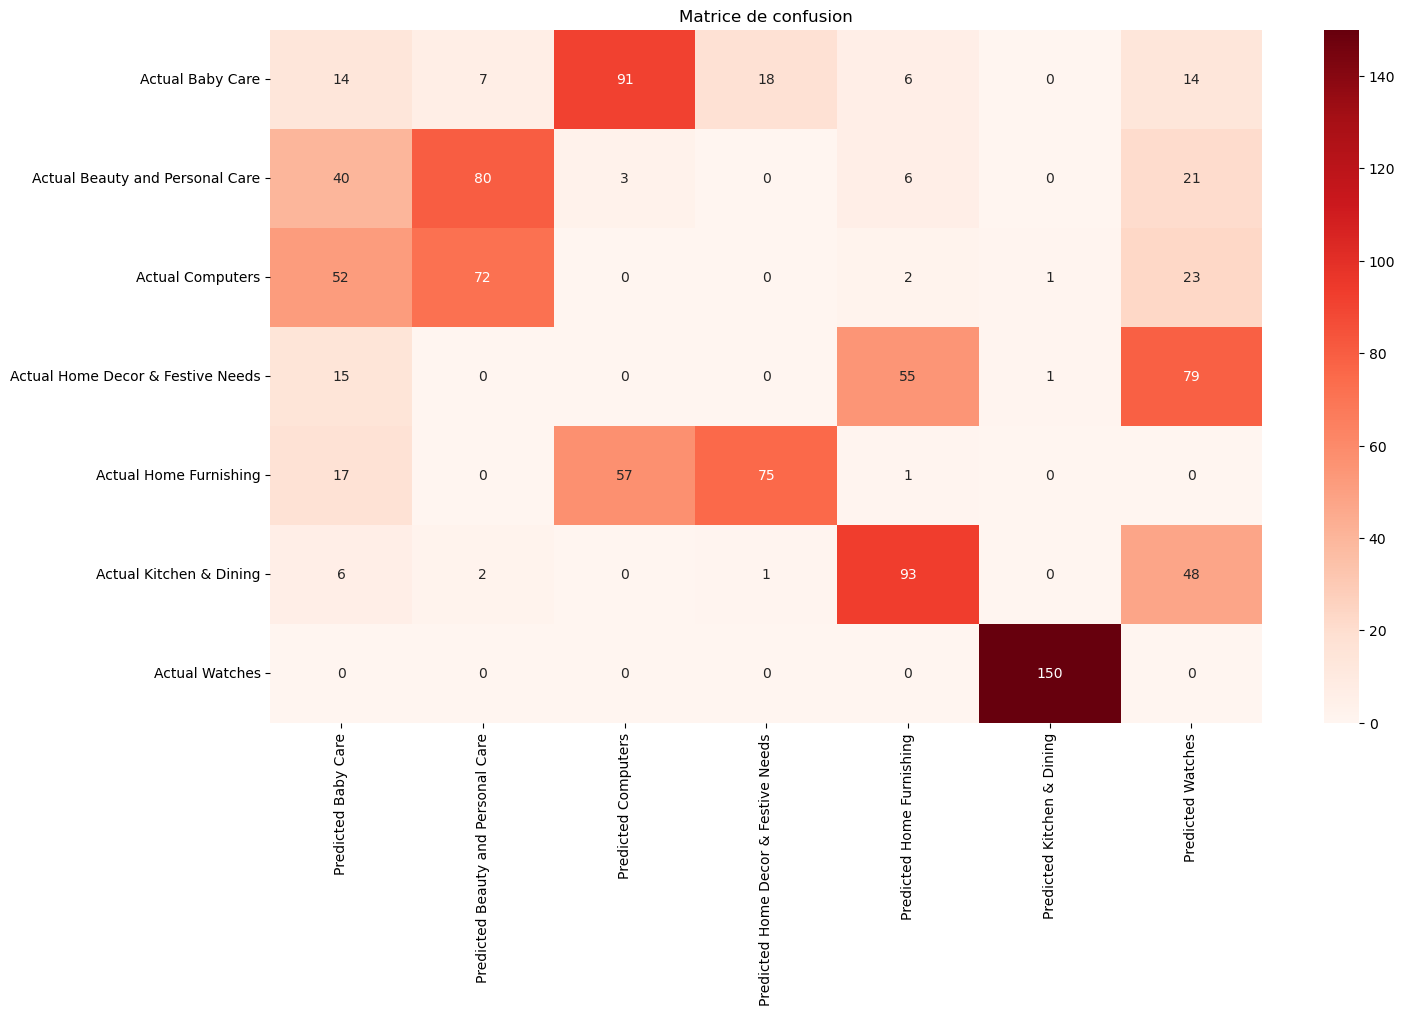

Rapport de classification :


,precision,recall,f1-score,support
0,0.097222,0.093333,0.095238,150.000000
1,0.496894,0.533333,0.514469,150.000000
2,0.000000,0.000000,0.000000,150.000000
3,0.000000,0.000000,0.000000,150.000000
4,0.006135,0.006667,0.006390,150.000000
5,0.000000,0.000000,0.000000,150.000000
6,0.000000,0.000000,0.000000,150.000000
accuracy,0.090476,0.090476,0.090476,0.090476
macro avg,0.085750,0.090476,0.088014,1050.000000
weighted avg,0.085750,0.090476,0.088014,1050.000000


In [93]:
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap="Reds") 
plt.title('Matrice de confusion')
plt.show()
print("Rapport de classification :")
classification_report_df

## <a name="C4"> Conclusion</a>


Notre mission consistait à évaluer la faisabilité de la classification automatique des articles sur notre marketplace à partir des descriptions textuelles et des images. À travers ce projet, nous avons exploré diverses techniques de prétraitement, d'extraction de features et de réduction dimensionnelle pour analyser et visualiser les données. Les résultats obtenus nous permettront de déterminer si une telle automatisation est viable et comment elle pourrait améliorer l'expérience utilisateur. En conclusion, cette étude de faisabilité est une étape cruciale vers la mise en place d'un système de classification robuste et efficace, facilitant la mise en ligne des articles par les vendeurs et la recherche de produits par les acheteurs.